# About

SHiP track pattern recognition is in this notebook.

# Data

In [2]:
from IPython.parallel import Client

clients = Client()
print clients.ids

[0, 1, 2]


In [3]:
%%px
import os, sys
sys.path.append('../functions')
sys.path.append('Github/ship_tracks_recognition/functions')

import numpy
import pandas

In [4]:
%matplotlib inline
import os, sys
sys.path.append('../functions')
import pandas
import numpy
import matplotlib.pyplot as plt
import cPickle as pickle

In [5]:
all_mctracks = pandas.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pandas.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pandas.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index

# Get reconstructible events

In [6]:
from utils import get_reconstractible_events
#reconstructible_events = get_reconstractible_events(range(0, 2500), all_hits, all_mctracks, all_velo_points)

# file_pickle = open('./Data/reco_tracks_for_pattern_recognition.pkl', 'wb')
# pickle.dump(reconstructible_events, file_pickle)
# file_pickle.close()

file_pickle = open('./Data/reco_tracks_for_pattern_recognition.pkl', 'rb')
reconstructible_events_pkl = pickle.load(file_pickle)
file_pickle.close()

reconstructible_events = reconstructible_events_pkl

In [7]:
# reconstructible_events_valid = get_reconstractible_events(range(2500, 5000), all_hits, all_mctracks, all_velo_points)

# file_pickle = open('./Data/reco_tracks_for_pattern_recognition_valid.pkl', 'wb')
# pickle.dump(reconstructible_events_valid, file_pickle)
# file_pickle.close()

file_pickle = open('./Data/reco_tracks_for_pattern_recognition_valid.pkl', 'rb')
reconstructible_events_valid_pkl = pickle.load(file_pickle)
file_pickle.close()

reconstructible_events_valid = reconstructible_events_valid_pkl

In [8]:
numpy.array(reconstructible_events.keys())

array([ 513,    2,  515,  516, 1541,  518,    7,   10, 2059, 1036, 1550,
         15, 2392, 1042, 1557,   23,   27, 2077, 2132, 1057,  549,   39,
       1066, 2482,  558, 2095,   48,  928,   50, 2099,   53, 1204, 1546,
         62, 1600, 2113, 1090, 1206, 1606, 1607, 1548,   74, 1293, 2232,
         84,   85,   86, 1111, 2138, 1116, 1629,  606, 1893,  608,   97,
       1979,  612, 1637,  614, 1129,  106, 1895, 2305, 2157,  622, 1213,
       1136,  625, 1138, 2164, 1142, 1655,  122, 1385,  126,  686,  129,
        642,  131, 1668, 1157,  134,  135,  648, 1280,  651, 1677,  654,
        143, 1683, 1691, 2204, 1693,  670,  159, 2208,  161, 2246, 1190,
       1704,  174,  824, 2224, 1224,  179,  692, 1717,  694,  184, 1722,
       1724,  189, 2239,  707, 2244, 1967, 1222,  712, 1200, 1900,  719,
       1232, 2446,  211, 2260, 1238,  215, 2264, 1242, 1243, 1756,  221,
       1758, 2271,  736, 1761, 1762, 1251, 2277, 1256, 1769, 2282,  747,
       2429, 2002, 1262,  893, 1265, 2290, 1235, 22

# Stations 1&2

## Classifiers

In [51]:
from sklearn.linear_model import LinearRegression
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier

def get_zy_track(hits):
    
    XX = hits.Wz.values
    yy = hits.Wy.values
    rr = 1*hits.dist2Wire.values
    ii = hits.index.values

    X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
    y = numpy.concatenate((yy+rr, yy-rr), axis=0)
    indeces = numpy.concatenate((ii, ii), axis=0)

    rmlr = MultiLinearRegression(n_tracks=1, 
                                 n=n, 
                                 subsample=1, 
                                 n_neighbors=20, 
                                 step=0.1,
                                 track_classifier=None,
                                 hit_classifier=None)
    rmlr.fit(X, y)
    
    tracks = rmlr.tracks_
    tracks_labels = rmlr.labels_
        
    return tracks

def get_data_zy_classifier(hits_zy, events, stations):

    data_zy_track = pandas.DataFrame(columns=['score', 'k', 'b', 'label'])
    data_zy_hit = pandas.DataFrame(columns=['dist', 'k', 'b', 'label'])

    for event_id in events:

        event = hits_zy[hits_zy.event == event_id]

#         track2 = event[numpy.abs(event.PdgCode) == 211]
#         track3 = event[numpy.abs(event.PdgCode) == 13]
        track2 = event[event.TrackID == 2]
        track3 = event[event.TrackID == 3]

        if len(track2)==0 or len(track3)==0:
            continue

        X1 = track2.Z.values.reshape(-1, 1)
        y1 = track2.Y.values

        X2 = track3.Z.values.reshape(-1, 1)
        y2 = track3.Y.values


        X = event.Z.values.reshape(-1, 1)
        y = event.Y.values


        mlr = JustLinearRegression()
        score, lr = mlr.fit(X1, y1)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 1]


        for ind in range(len(X)):
            data_zy_hit.loc[len(data_zy_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (event.TrackID.values[ind] == 2) * 1]


        mlr = JustLinearRegression()
        score, lr = mlr.fit(X2, y2)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 1]


        for ind in range(len(X)):
            data_zy_hit.loc[len(data_zy_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (event.TrackID.values[ind] == 3) * 1]


        X = numpy.concatenate((X1[track2.StatNb == stations[0]], X2[track3.StatNb == stations[1]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[0]], y2[track3.StatNb == stations[1]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 0]

        X = numpy.concatenate((X1[track2.StatNb == stations[1]], X2[track3.StatNb == stations[0]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[1]], y2[track3.StatNb == stations[0]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)
        data_zy_track.loc[len(data_zy_track)] = [score, lr.coef_[0], lr.intercept_, 0]

    return data_zy_track, data_zy_hit

def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits

def get_data_zx_classifier(hits_zy, hits_zx, events, stations):

    data_zx_track = pandas.DataFrame(columns=['score', 'k', 'b', 'label'])
    data_zx_hit = pandas.DataFrame(columns=['dist', 'k', 'b', 'label'])

    for event_id in events:

        event = hits_zy[hits_zy.event == event_id]

#         track2 = event[numpy.abs(event.PdgCode) == 211]
#         track3 = event[numpy.abs(event.PdgCode) == 13]
        track2 = event[event.TrackID == 2]
        track3 = event[event.TrackID == 3]

        if len(track2)==0 or len(track3)==0:
            continue

        X1 = track2.Z.values.reshape(-1, 1)
        y1 = track2.Y.values

        X2 = track3.Z.values.reshape(-1, 1)
        y2 = track3.Y.values

        mlr = JustLinearRegression()
        score, lr = mlr.fit(X1, y1)


        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        Cx = stereo_hits.Wz.values.reshape(-1, 1)
        Cy = stereo_hits.Wx.values
        R = stereo_hits.dist2Wire.values / numpy.sin(10. * numpy.pi / 360.)
        Tx = stereo_hits.Z.values.reshape(-1, 1)
        Ty = stereo_hits.X.values
        X = Cx
        y = (Cy <= Ty) * (Cy + R) + (Cy > Ty) * (Cy - R)
        stereo_X = X[stereo_hits.TrackID == 2]
        stereo_y = y[stereo_hits.TrackID == 2]
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 1]
        for ind in range(len(X)):
            data_zx_hit.loc[len(data_zx_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (stereo_hits.TrackID.values[ind] == 2) * 1]


        mlr = JustLinearRegression()
        score, lr = mlr.fit(X2, y2)


        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        Cx = stereo_hits.Wz.values.reshape(-1, 1)
        Cy = stereo_hits.Wx.values
        R = stereo_hits.dist2Wire.values / numpy.sin(10. * numpy.pi / 360.)
        Tx = stereo_hits.Z.values.reshape(-1, 1)
        Ty = stereo_hits.X.values
        X = Cx
        y = (Cy <= Ty) * (Cy + R) + (Cy > Ty) * (Cy - R)
        stereo_X = X[stereo_hits.TrackID == 3]
        stereo_y = y[stereo_hits.TrackID == 3]
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 1]
        for ind in range(len(X)):
            data_zx_hit.loc[len(data_zx_hit)] = [numpy.abs(y[ind] - lr.predict(X[ind].reshape(-1, 1)))[0], 
                                                 lr.coef_[0], 
                                                 lr.intercept_, 
                                                 (stereo_hits.TrackID.values[ind] == 3) * 1]


        X = numpy.concatenate((X1[track2.StatNb == stations[0]], X2[track3.StatNb == stations[1]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[0]], y2[track3.StatNb == stations[1]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)

        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits.Z.values.reshape(-1, 1)
        stereo_y = stereo_hits.X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 0]

        X = numpy.concatenate((X1[track2.StatNb == stations[1]], X2[track3.StatNb == stations[0]]), axis=0) 
        y = numpy.concatenate((y1[track2.StatNb == stations[1]], y2[track3.StatNb == stations[0]]), axis=0)
        mlr = JustLinearRegression()
        score, lr = mlr.fit(X, y)

        stereo_hits = get_zx_hits(event_id, hits_zx, lr.coef_[0], lr.intercept_)
        X = stereo_hits.Z.values.reshape(-1, 1)
        y = stereo_hits.X.values
        stereo_X = stereo_hits.Z.values.reshape(-1, 1)
        stereo_y = stereo_hits.X.values
        mlr = JustLinearRegression()
        score, lr = mlr.fit(stereo_X, stereo_y)
        data_zx_track.loc[len(data_zx_track)] = [score, lr.coef_[0], lr.intercept_, 0]

    return data_zx_track, data_zx_hit

def get_track_classifier(data):

    X_data = data[['score', 'k', 'b']].values
    y_data = data[['label']].values.reshape(-1)
    
    xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                                 subsample=0.5, max_depth=8)
    
    classifier = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
    classifier.fit(X_data, y_data)
    
    return classifier

def get_hit_classifier(data):

    X_data = data[['dist', 'k', 'b']].values
    y_data = data[['label']].values.reshape(-1)
    
    xgb_base = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.1, nthreads=3, 
                                 subsample=0.5, max_depth=8)
    
    classifier = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
    classifier.fit(X_data, y_data)
    
    return classifier

In [53]:
from Y_views import *
from UV_views import *
hits_zy_12, _ = modify_for_yz_analysis_1_2(all_hits)
hits_zx_12, _ = modify_for_xz_analysis_1_2(all_hits)


def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits

data_zy_track, data_zy_hit = get_data_zy_classifier(hits_zy_12, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[1,2])

data_zx_track, data_zx_hit = get_data_zx_classifier(hits_zy_12, 
                                                    hits_zx_12, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[1,2])

clf_zy_track = get_track_classifier(data_zy_track)
clf_zy_hit = get_hit_classifier(data_zy_hit)

clf_zx_track = get_track_classifier(data_zx_track)
clf_zx_hit = get_hit_classifier(data_zx_hit)

classifiers_12 = [None, clf_zy_hit, None, clf_zx_hit]

## Y-views

In [12]:
%%px
from MultiLinearRegression import MultiLinearRegression

def get_zy_candidates(event_id, data, track_classifier, hit_classifier):
    
    event = data[data['event'] == event_id]
    
    n = 3
    if len(event) > 40:
        n = 3

    XX = event.Wz.values
    yy = event.Wy.values
    rr = 1*event.dist2Wire.values
    ii = event.index.values

    X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
    y = numpy.concatenate((yy+rr, yy-rr), axis=0)
    indeces = numpy.concatenate((ii, ii), axis=0)

    rmlr = MultiLinearRegression(n_tracks=2, 
                                 n=n, 
                                 subsample=1, 
                                 n_neighbors=20, 
                                 step=0.1,
                                 track_classifier=track_classifier,
                                 hit_classifier=hit_classifier)
    rmlr.fit(X, y)
    
    tracks = rmlr.tracks_
    tracks_labels = rmlr.labels_

    tracks_yz = {}
    linking_table_yz = {}

    for num, track in enumerate(tracks):
        track_ids = indeces[tracks_labels == num]
        if len(track_ids) != 0:
            tracks_yz[num + 1] = track
            linking_table_yz[num + 1] = numpy.unique(track_ids)
        
    return tracks_yz, linking_table_yz

def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits[numpy.abs(stereo_hits.Wx.values) < 300]


def get_zx_candidates(event_id, tracks_yz, tracks_cov_yz, data, track_classifier, hit_classifier):

    tracks_xz = {}
    linking_table_xz = {}

    for num, track_id in enumerate(tracks_yz.keys()):

        zy_plane_k, zy_plane_b = tracks_yz[track_id]
        cov = tracks_cov_yz[track_id]

        hits = get_zx_hits(event_id, data, zy_plane_k, zy_plane_b)

        XX = hits.Wz.values
        yy = hits.Wx.values
        rr = 1*hits.dist2Wire.values / numpy.sin(10. * numpy.pi / 360.)
        ii = hits.index.values

        X = numpy.concatenate((XX, XX), axis=0).reshape((-1, 1))
        y = numpy.concatenate((yy+rr, yy-rr), axis=0)
        indeces = numpy.concatenate((ii, ii), axis=0)
        
        rmlr = MultiLinearRegression(n_tracks=1, 
                                 n=3, 
                                 subsample=1, 
                                 n_neighbors=20, 
                                 step=0.1,
                                 track_classifier=track_classifier, 
                                 hit_classifier=hit_classifier)
        rmlr.fit(X, y)

        tracks = rmlr.tracks_
        tracks_labels = rmlr.labels_

        track_inds = indeces[tracks_labels == 0]
        if  len(track_inds) != 0:
            linking_table_xz[track_id * 10000 + (num+1)] = list(numpy.unique(track_inds))
            tracks_xz[track_id * 10000 + (num+1)] = tracks[0]

    return tracks_xz, linking_table_xz

def run_stations(event_id, data_zy, data_zx, classifiers):

    reco_events12 = {}

    tracks_yz, linking_table_yz = get_zy_candidates(event_id, data_zy, classifiers[0], classifiers[1])
    tracks_xz, linking_table_xz = get_zx_candidates(event_id, tracks_yz, linking_table_yz, data_zx, classifiers[2], classifiers[3])

    reco = [tracks_yz, linking_table_yz, tracks_xz, linking_table_xz]

    reco_events12[event_id] = reco

    print event_id

    return reco_events12

def merge_dicts(dicts):
    '''
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    '''
    result = {}
    for dictionary in dicts:
        result.update(dictionary)
    return result

In [54]:
%%time
view = clients.load_balanced_view()
event_ids = reconstructible_events.keys()
res = view.map(run_stations, 
               event_ids, 
               [hits_zy_12]*len(event_ids), 
               [hits_zx_12]*len(event_ids), 
               [classifiers_12]*len(event_ids))

reco_events12 = merge_dicts(res.get())

CPU times: user 18.7 s, sys: 31.7 s, total: 50.4 s
Wall time: 39min 22s


In [55]:
file_pickle = open('./Data/reco_events12_model_1_hits_clf.pkl', 'wb')
pickle.dump(reco_events12, file_pickle)
file_pickle.close()

file_pickle = open('./Data/reco_events12_model_1_hits_clf.pkl', 'rb')
reco_events12_pkl = pickle.load(file_pickle)
file_pickle.close()

reco_events12 = reco_events12_pkl

# Stations 3&4

In [56]:
from Y_views import *
from UV_views import *
hits_zy_34, _ = modify_for_yz_analysis_3_4(all_hits)
hits_zx_34, _ = modify_for_xz_analysis_3_4(all_hits)


def get_zx_hits(event_id, data, plane_k, plane_b):

    stereo_hits = data[data['event'] == event_id]

    stereo_hits['Wy'] = plane_k * stereo_hits.Wz.values + plane_b
    stereo_hits['Wx'] = (stereo_hits.Wx2.values - stereo_hits.Wx1.values) / (stereo_hits.Wy2.values - stereo_hits.Wy1.values) * \
                        (stereo_hits.Wy.values - stereo_hits.Wy1.values) + stereo_hits.Wx1.values

    return stereo_hits


data_zy_track, data_zy_hit = get_data_zy_classifier(hits_zy_34, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[3,4])

data_zx_track, data_zx_hit = get_data_zx_classifier(hits_zy_34, 
                                                    hits_zx_34, 
                                                    reconstructible_events_valid.keys(), 
                                                    stations=[3,4])

clf_zy_track = get_track_classifier(data_zy_track)
clf_zy_hit = get_hit_classifier(data_zy_hit)

clf_zx_track = get_track_classifier(data_zx_track)
clf_zx_hit = get_hit_classifier(data_zx_hit)

classifiers_34 = [None, clf_zy_hit, None, clf_zx_hit]

In [57]:
%%time
view = clients.load_balanced_view()
event_ids = reconstructible_events.keys()
res = view.map(run_stations, 
               event_ids, 
               [hits_zy_34]*len(event_ids), 
               [hits_zx_34]*len(event_ids), 
               [classifiers_34]*len(event_ids))

reco_events34 = merge_dicts(res.get())

CPU times: user 15.4 s, sys: 23 s, total: 38.4 s
Wall time: 22min 43s


In [58]:
file_pickle = open('./Data/reco_events34_model_1_hits_clf.pkl', 'wb')
pickle.dump(reco_events34, file_pickle)
file_pickle.close()

file_pickle = open('./Data/reco_events34_model_1_hits_clf.pkl', 'rb')
reco_events34_pkl = pickle.load(file_pickle)
file_pickle.close()

reco_events34 = reco_events34_pkl

# Combination tracks

### Data Preparation

In [59]:
from MatchTracks import get_dx_dy, get_true_label, get_matching_data, get_new_matched_tracks, get_true_match

data = get_matching_data(reco_events12, reco_events34, all_hits)


data['dk_xz'] = data['k_xz_34'].values - data['k_xz_12'].values
data['db_xz'] = data['b_xz_34'].values - data['b_xz_12'].values
data['dk_yz'] = data['k_yz_34'].values - data['k_yz_12'].values
data['db_yz'] = data['b_yz_34'].values - data['b_yz_12'].values


X_data = data[[u'dx', u'dy', 
          u'k_xz_12', u'b_xz_12', 
          u'k_yz_12',u'b_yz_12', 
          u'k_xz_34', u'b_xz_34', 
          u'k_yz_34', u'b_yz_34', 
          'dk_xz', 'db_xz', 
          'dk_yz', 'db_yz']].values
y_data = data[['label']].values.reshape(-1)

### Train Classifier

In [60]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier


from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=3, 
                             subsample=0.5, max_depth=8)
folding = FoldingClassifier(xgb_base, n_folds=10, random_state=11)
%time folding.fit(X_data, y_data)

CPU times: user 21.3 s, sys: 12 s, total: 33.2 s
Wall time: 19.6 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=8, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.5, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13'],
         n_folds=10, parallel_profile=None, random_state=11)

### Prediction and Quality

KFold prediction using folds column
KFold prediction using folds column
0.999940103023


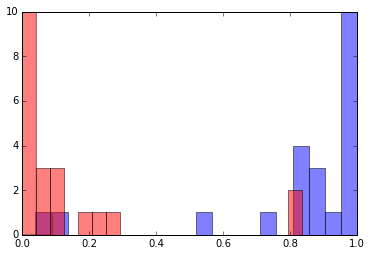

In [61]:
y_proba = folding.predict_proba(X_data)[:, 1]
y_predict = folding.predict(X_data)

from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data, y_proba)

plt.hist(y_proba[y_data==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba[y_data==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,10)
plt.show()

### Tracks Combination

In [62]:
match_tracks = {}
for event_id in reco_events12.keys():
    
    ids = data[data.EventID.values == event_id][['track_id_12', 'track_id_34']].values
    probas = y_proba[data.EventID.values == event_id]
    
    match_tracks[event_id] = ids[probas.argsort()[::-1], :][:2, :]
    #match_tracks[event_id] = ids[probas > 0.5, :]
    if len(match_tracks[event_id]) < 2:
        print event_id

In [63]:
charge_dict, pinv_dict, dist_y, dist_x = get_new_matched_tracks(reco_events12, reco_events34, match_tracks)

true_charge_dict, true_pdg_dict, true_pinv_dict = get_true_match(reco_events12, reco_events34, match_tracks, all_hits)

# Efficiency

### Stations 1&2

In [64]:
from efficiency import efficiency_per_track

event_id = numpy.array(reco_events12.keys())
eff_y, eff_stereo, eff_station = efficiency_per_track(event_id, 
                                            all_hits, 
                                            reco_events12)

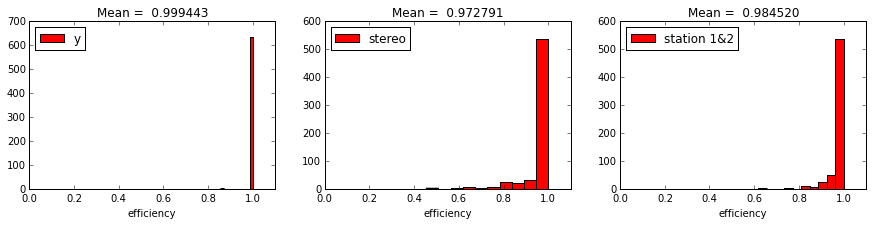

In [65]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.show()

### Stations 3&4

In [66]:
from efficiency import efficiency_per_track

eff_y, eff_stereo, eff_station = efficiency_per_track(reco_events34.keys(), 
                                            all_hits, 
                                            reco_events34)

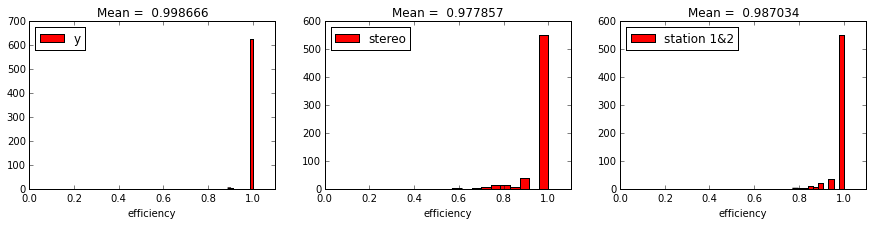

In [67]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.subplot(1,3,2)
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.subplot(1,3,3)
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('efficiency')
plt.xlim(0, 1.1)
plt.legend(loc='best')

plt.show()

# Efficiency per event

Total efficiency per event is  97.4842767296  %


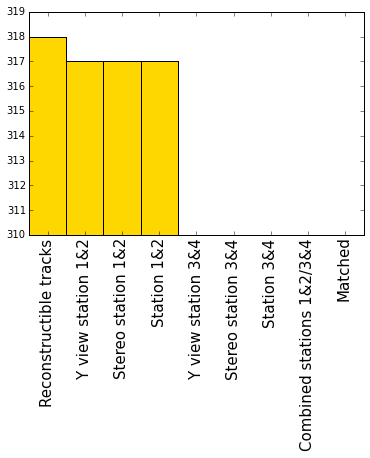

In [68]:
from efficiency import efficiency_per_event, view_check_reco_event

n_events, missed_events = efficiency_per_event(reconstructible_events, 
                                               reco_events12, 
                                               reco_events34, 
                                               match_tracks, 
                                               true_pdg_dict, 
                                               all_hits)

n_events = numpy.array(n_events)

labels = ['Reconstructible tracks', 
          'Y view station 1&2', 
          'Stereo station 1&2', 
          'Station 1&2',
          'Y view station 3&4', 
          'Stereo station 3&4',
          'Station 3&4',
          'Combined stations 1&2/3&4',
          'Matched']

print 'Total efficiency per event is ', 1. * n_events[-1] / n_events[0] * 100., ' %'

x = range(len(labels))
#plt.figure(figsize=(15,5))
plt.bar(x, n_events, width=1., color='gold', align='center')
plt.xticks(x, labels, rotation=90, size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(n_events.min(), n_events.max() + 1)
plt.show()

In [69]:
print n_events
print missed_events

[ 318.  317.  317.  317.  310.  310.  310.  310.  310.]
[2040, 143, 670, 1722, 1756, 270, 426, 1528]


# Momentum

y = b + kx
k, b =  0.00302865273075 0.00204919088402
Cov matrix is 
[[  4.51111825e-06   4.54842680e-07]
 [  4.54842680e-07   3.03362117e-05]]


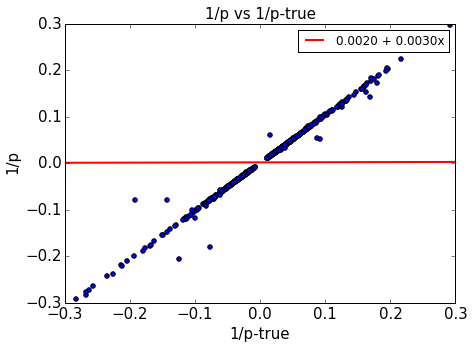

In [70]:
from MatchTracks import get_pinv_true_pinv
        
pinv, true_pinv = get_pinv_true_pinv(pinv_dict, true_pinv_dict, true_charge_dict)
pinv = pinv.reshape(-1)
        

[k, b], cov = numpy.polyfit(true_pinv, pinv, 1, cov=True)
print 'y = b + kx'
print 'k, b = ', k, b
print 'Cov matrix is '
print cov

plt.figure(figsize=(7, 5))
plt.title('1/p vs 1/p-true', size=15)
plt.scatter(true_pinv, pinv)
x = numpy.array([-0.3, 0.3])
plt.plot(x, k * x + b, color='r', linewidth=2, label='%.4f + ' % b + '%.4fx' % k)
plt.legend(loc='best')
plt.ylabel('1/p', size=15)
plt.xlabel('1/p-true', size=15)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

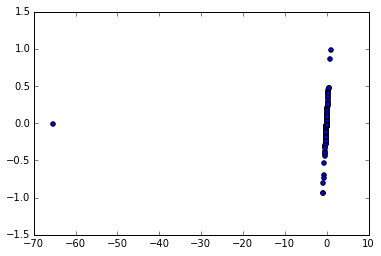

In [71]:
plt.scatter(true_pinv, pinv)
plt.show()

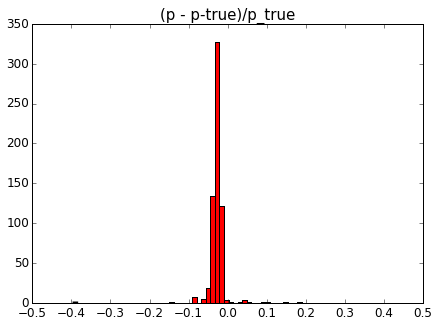

In [72]:
metric = true_pinv/pinv - 1

plt.figure(figsize=(7, 5))
plt.hist(metric[numpy.abs(metric) <= 0.5], bins=50)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()